# Introduction to Working with Filterbank Files
by Umran Haji, Undergraduate Research Intern

---

Welcome! In this tutorial I will demonstrate the basics of working with filterbank (`.fil`) files using [blimpy](https://github.com/UCBerkeleySETI/blimpy). Breakthrough Listen data from the Green Bank Telescope (GBT) is stored in filterbank format, so these skills will be of paramount importance to anyone who intends to work with such data for analysis and visualization purposes.

## 1. What are filterbank files and `blimpy`? 

Filterbank files are a binary data storage format which we use to store time series of power spectra. If that sounds like a bunch of confusing jargon, all it means is that a filterbank file stores information about how the power being collected by the GBT at many different frequencies of light changes over time. In addition to the stored data, a filterbank file contains a header that includes information about observation parameters, such as the date/time of the observation, the name of the target observed, and many other useful values which we will discuss later.

Since filterbank is a binary format, if you were to open up one of these files in a text editor, you would not be able to read it; you would just see a bunch of binary gibberish. This is where `blimpy` steps in. It includes a host of functions that parse the binary text in a filterbank file, and even defines a class, `Waterfall`, which you can use to instantiate any `.fil` file for easy extraction of the data objects as numpy arrays. In addition to importing the functions and class from `blimpy` into Python, you can also run it on any filterbank file from the command line to quickly view header info, generate plots, and so on.

In this tutorial I will demonstrate how to use `blimpy` within the Python interpreter for all the most essential purposes, namely extracting header information, extracting data and frequency arrays, and generating plots. 


## 2. Some Fun Physics Background

First, it's worth taking a little bit of time to discuss the basics of how in the world we even end up with a filterbank file after pointing our telescope somewhere! If you're not a physics/astro person (e.g. a computer science major), this will hopefully distill and demystify the nature of power spectra so that you understand what you are actually working with. And even if you do study physics/astronomy, you may find the following discussion an enlightening synthesis of your physics knowledge if you have never really thought about the process end-to-end.

Light is nothing more than an oscillating set of fields of electric and magnetic force that "feed off" each other (due to [Maxwell's equations](https://en.wikipedia.org/wiki/Electromagnetic_radiation#Maxwell.E2.80.99s_equations)) and thereby can propagate through space together. All that means is, if you were to take a tiny electrically charged particle (or magnetically charged particle, if [magnetic monopoles](https://en.wikipedia.org/wiki/Magnetic_monopole) existed) and shine some light at it, the particle would oscillate up and down (or in some other fashion, depending on the <a href="https://en.wikipedia.org/wiki/Polarization_(waves)"> polarization of the light</a>). 

If instead of a single charged particle you have an extended material with lots of loosely-held charges running around, e.g. a metal, the oscillating electric field in the light wave results in an oscillating voltage (and therefore an oscillating current) within the material, just as if it was hooked up to an AC voltage source that alternated at the same frequency as the light wave. In simpler terms, the oscillating electric field pushes and pulls charges (read: electrons) around in the material in an oscillatory manner. <a href="https://en.wikipedia.org/wiki/Antenna_(radio)#/media/File:Dipole_receiving_antenna_animation_6_800x394x150ms.gif">Here is a great animation</a> of exactly this process, and this is more or less how a radio antenna actually works. By measuring how the voltage difference across the antenna changes over time, one can learn about the incoming electromagnetic wave; the amplitude of the voltage difference is related to the amplitude of the electric field in the light wave, and the frequency of the voltage oscillation is the frequency of the light wave!

This is roughly what is happening at the GBT. A telescope is essentially a huge "light bucket"; the GBT collects copious amounts of light with its 100-meter primary mirror and directs it to a radio receiver which is something like an antenna, and oscillating voltage differences are induced in the receiver (the details are more complicated, but that is the general picture).

The only problem is, the telescope is being bombarded by light of a million different frequencies, so it is not that simple; because a radio antenna "sees" light coming from a huge variety of sources, the oscillations caused by their electric fields superpose on top of one another, making an extremely complicated oscillation pattern in the voltage. Luckily, we have [Fourier analysis](https://en.wikipedia.org/wiki/Fourier_series)! Fourier's Theorem says that any continuous or "[piecewise continuous](https://en.wikipedia.org/wiki/Piecewise)" periodic function (such as an oscillation!) can be expressed as a sum of simple sinusoidal functions, each with its own amplitude and frequency. <a href="http://toxicdump.org/stuff/FourierToy.swf?utm_source=feedburner&utm_medium=feed&utm_campaign=Feed%3A+hacker-news-feed-200+(Hacker+News+200)">Here is an amazing toy</a> (if it doesn't open, try a different browser) that lets you play around with this phenomenon; you can change the amplitudes of oscillations of a variety of given frequencies and observe how the oscillations add to create an amazing variety of shapes. 

Fourier's Theorem is hard to prove, but if you are mathematically inclined, with a little practice you too can [learn to compute the Fourier series for any elementary periodic function your heart desires!](http://www.stewartcalculus.com/data/CALCULUS%20Early%20Transcendentals/upfiles/FourierSeries5ET.pdf).

Fourier analysis is the greatest thing since before sliced bread (which wasn't first sold commercially until 98 years after Joseph Fourier's death) because of its implications in a huge variety of fields including observational astronomy. For our purposes, the upshot of Fourier analysis is that it allows any electromagnetic signal to be dissected into all of its component frequencies, each with its own amplitude, via an operation known as the "Fourier transform". Of course, doing it numerically, using observational data, is different from doing it for analytic functions, so computers have a numerical version known as a "fast Fourier transform" or FFT, but the basic idea is the same. If you have a plot of data points that shows "time" on the x-axis and "voltage difference" on the y-axis, for example, the FFT turns this into a plot that shows "frequency" on the x-axis and "amplitude" (or some related quantity such as "power") on y-axis. The resulting plot, in astronomical contexts, is known as a power spectrum.

The computers at GBT run FFTs on the so-called "raw voltage data" from an observation, and this is essentially how that data gets turned into our friend the filterbank file!

## 3. Loading in a Filterbank File + A First Look at Plots and Info

Most of the tools you will need for analyzing filterbank files are contained within the `Waterfall` class. To start out, clone the [Git repository](https://github.com/UCBerkeleySETI/blimpy) (or install with pip, by typing `pip install blimpy`). In my case, I have a `.fil` file in my working directory, so I just use the name of the file. You can also try downloading one of the files with File Type `filterbank` from the [Breakthrough Listen data archive](http://breakthroughinitiatives.org/opendatasearch).

In [1]:
from blimpy import Waterfall
 
fil = Waterfall('blc04_guppi_57563_69862_HIP35136_0011.gpuspec.0002.fil')

### Waterfall Plots

Now that we have done that, there are several things we can look at. Remember that a filterbank file shows how power varies with frequency and time. As such, it contains many **time integrations** (a time integration is just a period of time over which the light is collected), and each integration has a **power spectrum** associated with it. The data contained in the filterbank file therefore has three dimensions: frequency, power, and time. So, if I wanted to display all of the data contained in the filterbank file in one visualization, I would show it as a waterfall plot, like this:

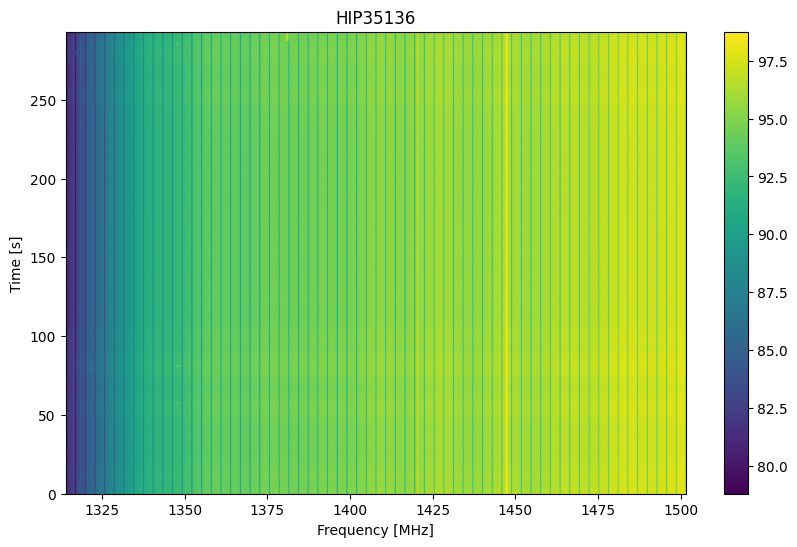

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
fil.plot_waterfall()

This **waterfall plot** shows exactly what we said at the beginning of this tutorial: how the power at a certain frequency is varying over time, where time increases as you move down the vertical axis. The colors represent the power values.

It's called a waterfall plot because if you were seeing the data come in in real time, the colors would move vertically at constant speed. In this case they would move downward, as the most recent data is at the top of the plot.

If you wanted to zoom in on a frequency range, you can use the `f_start` and `f_stop` arguments. There are also a few other optional arguments detailed in `blimpy` which I will skip over here.

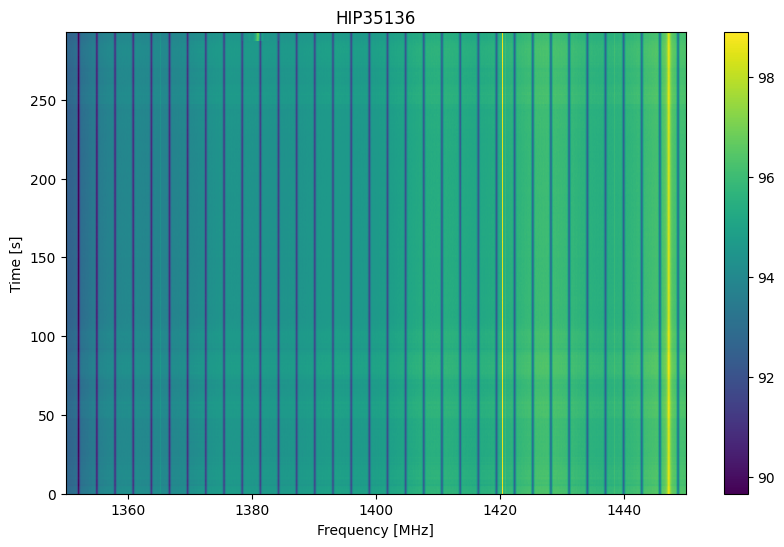

In [3]:
plt.figure(figsize=(10,6))
fil.plot_waterfall(f_start=1350, f_stop=1450)

### Power Spectrum for a Given Integration

Now imagine you were to pull a horizontal slice of the waterfall plot out of the screen like pulling a card out of a deck, and flip it 90 degrees so that the edge of the card that is initially closest to you is now on top. You would then be looking at a **power spectrum** for one particular **integration**. It shows frequency on the x-axis and power on the y-axis. We can display a power spectrum using another function contained in `blimpy`. Let's choose to display the 100th integration (which would be indexed as 99 since the integration indices start at 0):

extracting integration 99...


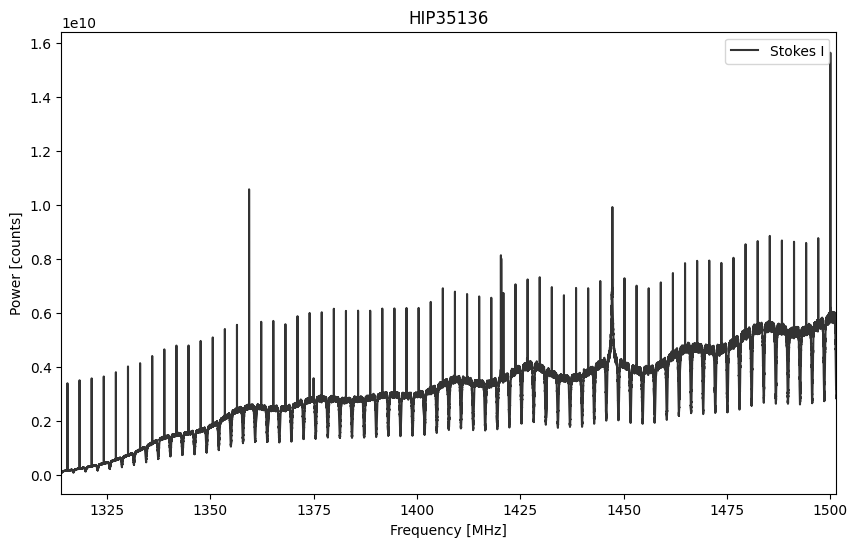

In [4]:
plt.figure(figsize=(10,6))
fil.plot_spectrum(t=99) #Leaving arguments blank will cause it to show integration 0 by default

You can ignore the evenly-spaced, equally-tall spikes throughout the spectrum; those are artifacts caused by [band-pass filters](https://en.wikipedia.org/wiki/Band-pass_filter) (they are also the cause of the dark vertical lines in the waterfall plot). 

We can also use the same arguments as before to zoom in on a region. A strong and well-known feature of interest here is the spike at approximately 1420 MHz; it is an emission line of hydrogen known as the [21-centimeter line](https://en.wikipedia.org/wiki/Hydrogen_line), on account of its wavelength which is approximately 21 cm.

extracting integration 99...


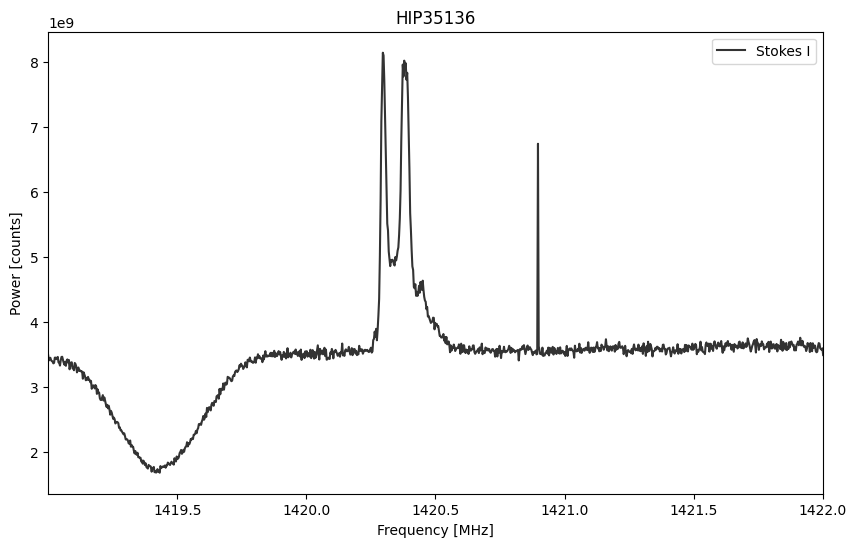

In [5]:
plt.figure(figsize=(10,6))
fil.plot_spectrum(t=99, f_start=1419, f_stop=1422)

### Header Information

We can use another function to easily print the header information from the file:

In [6]:
fil.info()


--- File Info ---
     rawdatafile : guppi_57563_69862_HIP35136_0011.0000.raw
     source_name :                         HIP35136
      machine_id :                               20
    telescope_id :                                6
         src_raj :                      7:15:50.064
         src_dej :                      47:14:20.04
        az_start :                              0.0
        za_start :                              0.0
       data_type :                                1
            fch1 :           1501.4634132385254 MHz
            foff :         -0.00286102294921875 MHz
          nchans :                            65536
          nbeams :                                1
           ibeam :                                1
           nbits :                               32
   tstart (ISOT) :          2016-06-24T19:24:22.000
    tstart (MJD) :               57563.808587962965
           tsamp :               1.0737418239999998
            nifs :                   

There are many useful pieces of information here, which you wil probably use at some point or another. I'll explain the most important ones, but all the header keywords are detailed in `blimpy`:

- **`source_name`**: The name of the target observed. In this case it is HIP35136, a star listed in the [Hipparcos catalog](https://en.wikipedia.org/wiki/Hipparcos).
- **`tstart`**: The start date of the observation, in [Modified Julian Date](https://en.wikipedia.org/wiki/Julian_day) format
- **`src_raj`**: The [right ascension](https://en.wikipedia.org/wiki/Equatorial_coordinate_system) of the target in hours:minutes:seconds.
- **`src_dej`**: The [declination](https://en.wikipedia.org/wiki/Equatorial_coordinate_system) of the target in degrees:arcminutes:arcseconds.
- **`nchans`**: The number of channels (i.e. frequency bins)
- **`fch1`**: The center frequency of the first channel (i.e. the highest-frequency channel).
- **`foff`**: The bandwidth of each channel, in MHz. It is negative because the channels are numbered in increasing order as they decrease in frequency.



## 4. Getting Your Hands on the Actual Data

Now that I've showed you how to visualize the data and print the header info, I'll show you how to extract the data so that you can use it for analysis purposes.

### Extracting Frequency Bins

First let's get ahold of the values of the center frequencies of the channels. This is easy to do:

In [7]:
freqs = fil.freqs
print freqs
print type(freqs)

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(...)? (197852516.py, line 2)

As you can see, we get the frequencies in MHz in a 1-D `numpy` array.

### Extracting Power Data

Now let's take a look at the object that contains the actual power values:

In [ ]:
data = fil.data
print data.shape
print type(data)

The power values are stored in a 3-D `numpy` array. The first dimension corresponds to the number of integrations in the file (notice from the header info above that "`num ints in file:`" reads 273). Meanwhile the third dimension corresponds to the number of frequency channels (notice in the header that "`nchans:`" reads 65536).

So, by picking a value along the zeroth axis (i.e. first dimension) of the array, I can extract the power values associated with that integration. The array of power values will have length 65536, since there is one power value associated with each channel.

For example, suppose I want to get the power values from integration 100 (index 99) as before. For this I simply do:

In [ ]:
powers100 = data[99]
print powers100
powers100 = powers100[0]
print powers100
print len(powers100)

(The extra 0 index at the end is necessary to isolate the values in a 1-D array).

Now we have the power values for integration 100, and sure enough, the array has the expected length. If you were to find the length of the `freqs` array, you would see that it is also 65536.

These power values line up with the values of the frequencies. For example, from the `freqs` array and the `powers100` array we see that in the first channel, which is centered at `1313.96627426` MHz, the power value is `7.93240480e+07`.

We can now do whatever we like with these frequencies and power values. For demonstration, I'll plot the values for integration 100, just to show that we get the same plot as when we called `fil.plot_spectrum(t=99)`:

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(freqs, powers100)
plt.xlim(freqs[0], freqs[-1])
plt.show()

### Extracting Header Parameters + A Word of Advice

Whereas the `self.info()` method just prints the header information, use `self.header` to get the header in the form of a Python dictionary:

In [ ]:
header = fil.header
print header

Testing out the extraction of a parameter:

In [ ]:
nchans = header['nchans']
print nchans

Now, here is a word of advice regarding extracting header information: If you ever find yourself running some sort of code that is only interested in the header information of filterbank files and doesn't care about the data itself (say, for example, you are running some code that checks filterbank files to see if a value in their headers fulfills a certain condition), you should **NOT** use the `self.header` method contained in the `Waterfall` class. 

The reason why you should not do this is because, when you instantiate a file as a member of the `Waterfall` class, `blimpy` will parse the *entire* file, including not only the header but also the data. The small amount of extra time required for this will compound dramatically if you are running something on a large number of filterbank files, and especially if you are working with large files (the files that have all the pieces of the band spliced together, for example, are half a gigabyte in size at minimum).

If you are interested only in the header information of a filterbank file, you should instead use the `read_header` function from `blimpy`, as it parses the header from binary without parsing the data arrays:

In [ ]:
from blimpy import read_header

header2 = read_header('blc04_guppi_57563_69862_HIP35136_0011.gpuspec.0002.fil')
print header2

The resultant dictionary contains all the same information as the one you obtain from `self.header`.

## 5. Miscellaneous Helpful Functions

Here are some miscellaneous functions that I have written during my time with Breakthrough Listen that you may find useful:

In [ ]:
"""
All these functions show the required modules imported within the function. This is simply to show as
clearly as possible which modules are required by each function. Of course, in general you should 
import all modules at the top of your script.
"""

def maxfreq(file):
    """Return central frequency of the highest-frequency bin in a .fil file.""" 
    
    from blimpy import read_header
    return read_header(file)['fch1']

def minfreq(file):
    """Return central frequency of the lowest-frequency bin in a .fil file"""
    
    from blimpy import read_header
    fch1 = read_header(file)['fch1']
    nchans = read_header(file)['nchans']
    ch_bandwidth = read_header(file)['foff']
    return fch1 + nchans*ch_bandwidth

def currentMJD():
    """Returns current MJD including decimals."""
    
    from astropy.time import Time
    print Time.now().mjd 

def AA(file): 
    """Returns Alt-Az coordinates (deg) for a given GBT .fil file.
    
    Args:
        file (str): .fil file
        
    Returns:
        altazdict (dict): Dictionary with alt and az in degrees.
    """
    
    from astropy import units as u
    from astropy.time import Time
    from astropy.coordinates import EarthLocation, SkyCoord, AltAz
    from blimpy import read_header
    
    GreenBank = EarthLocation(lat=38.4322*u.deg, lon=-79.8398*u.deg) #Western longitudes are negative
    MJD = read_header(file)['tstart']
    ra = read_header(file)['src_raj']
    dec = read_header(file)['src_dej']
    target = SkyCoord(ra, dec)
    altaz = target.transform_to(AltAz(location=GreenBank, obstime=Time(MJD, format='mjd')))
    altazdict = { 'alt' : altaz.alt.degree, 'az' : altaz.az.degree }
    return altazdict

def totalpower(file, integration, fmin, fmax): 
    
    """Use Simpson's rule numerical integration to find total power between 
    given freq bounds, for given time integration.
    
    Args:
        file (str): .fil file
        integration (int): .fil file integration number to analyze
        fmin (float): Lower freq bound
        fmax (float): Upper freq bound
        
    Returns:
        totalpower (float): total power (from Simpson's rule)
                            under the power spectrum curve 
                            between fmin and fmax
    """
    
    import numpy as np
    from scipy.integrate import simps
    from blimpy import read_header, Waterfall
    
    #Check for valid bounds
    maxfreq = read_header(file)['fch1']
    nchans = read_header(file)['nchans']
    ch_bandwidth = read_header(file)['foff']
    minfreq = maxfreq + nchans*ch_bandwidth
    if fmin < minfreq or fmax > maxfreq:
        raise ValueError("One of your freq constraints is out of the freq range of this filterbank file.")
    
    #Get data
    fil = Waterfall(file)
    freqs = np.array(fil.freqs)
    data = np.array(fil.data[integration][0]) 
    
    #Get freqs and power values from desired range
    idx = np.where(np.logical_and(freqs >= fmin, freqs <= fmax))
    newfreqs = freqs[idx]
    newdata = data[idx]
    
    #Integrate
    totalpower = simps(x=newfreqs, y=newdata)
    return totalpower

Congratulations! You now have everything you need to start working with filterbank data!